# Customer Churn Analysis

The assignment is to carry out the customer churn analysis for the gym chain and develope a customer interaction strategy based on it.

Data on churn for a given month, customers profiles and some information on their behavior on the month preceding it is available.

The purposes of the study are to:

* predict the probability of churn (for the upcoming month) for each customer
* analyze the factors that impact churn most
* draw up groups of user portraits and determine their main features
* develop a customer retention strategy and identify target groups

The work plan: 

<a href='#section1'>1. Getting the data and studying the general information</a>

<a href='#section2'>2. Exploratory data analysis</a>

<a href='#section3'>3. Building a model to predict customer churn</a>

<a href='#section4'>4. Clastering customers</a>

<a href='#section5'>5. Overall conclusion and basic recommendations</a>

In [1]:
# importing of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# some global constats for formatting the output string
BOLD = '\033[1m'
END = '\033[0m'

## 1. Getting the data and studying the general information
<a id='section1'></a>

In [2]:
# reading file that contains the data on churn of the gym chain
data = pd.read_csv('/datasets/gym_churn_us.csv')

# Let's look at the data's general information 
print(BOLD + 'General information:' + END)
print(data.info())
print()

# Let's look at the first few rows in the table
print(BOLD + 'The first few rows of the dataset(use scroll to see all collumns):' + END)
display(data.head())

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
None

The fir

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


The dataset contains  __4,000 customers profiles of the gym chain__.

Columns `'Near_Location'`, `'Partner'`, `'Promo_friends'`, `'Group_visits'`, `'Churn'` contain boolean values, and the column 'gender' contains encoding values of gender. For these columns it would be enough just __Boolean type__.

The values for the columns `'Contract_period'`, `'Age'`, `'Month_to_end_contract'` and `'Lifetime` are such that the type __int8__ would be enough for them.

There are no null values in the dataset.

## 2. Exploratory data analysis
<a id='section2'></a>

In [3]:
# Before EDA rename columns and convert excess types

# replacing the column names makeing them lowercase in oder to make it convenient to work with them
data.columns = data.columns.str.lower()

# converting excess type with help of astype() method:
data['gender'] = data.gender.astype('bool')  
data['near_location'] = data.near_location.astype('bool')  
data['partner'] = data.partner.astype('bool')  
data['promo_friends'] = data.promo_friends.astype('bool')  
data['phone'] = data.phone.astype('bool') 
data['group_visits'] = data.group_visits.astype('bool')  
data['churn'] = data.churn.astype('bool') 
data['contract_period'] = data.contract_period.astype('int8')
data['age'] = data.age.astype('int8') 
data['month_to_end_contract'] = data.month_to_end_contract.astype('int8') 
data['lifetime'] = data.lifetime.astype('int8') 

Feature names have been converted to lowercase for more convenient work with them. Excess types were converted to appropriate ones.

In [4]:
# Let's look at the features in more detail
# creating the corresponding lists of features of different types
boolean_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
int_cols = ['age', 'lifetime', 'contract_period', 'month_to_end_contract']
float_cols = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

# looking at the values that take numerical features 
print(BOLD + 'Descriptive statistics of numerical features:' + END)
display(data[int_cols + float_cols].describe().T)
print('\n')

# looking at the boolean features
print(BOLD + 'Observation shares for values of boolean features:' + END)
display(data[boolean_cols].apply(pd.Series.value_counts) / len(data) * 100)

Descriptive statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783




Observation shares for values of boolean features:


,gender,near_location,partner,promo_friends,phone,group_visits,churn
False,48.975,15.475,51.325,69.15,9.65,58.775,73.475
True,51.025,84.525,48.675,30.85,90.35,41.225,26.525


The age of the gym client varies from 18 to 41 years. The average client age is 29 years. On average, a client visits the gym for 3 months, there are clients who have been at the gym for more than 2.5 years. There are contracts from a month to a year. At least half of the clients only have one-month contracts. Clients spend on average \$150 on other gym services such as cafes, sporting goods, massage, etc., up to a maximum of \\$550. The average gym client works out twice a week. There are clients who visit the gym almost every day.

The distribution of men and women among the clients of the gym is approximately the same. 15% of the gym clients don't live or work in the neighborhood where the gym is located. Almost half of the clients are employees of a partner company. 30% of the gym clients are originally signed up through a "bring a friend" offer. Almost 10% of the clients didn't provide their phone numbers. About 40% of the clients took part in group sessions. The customer churn rate is about 26%.

The mean feature values in two groups: for those who left and for those who stayed:


churn,False,True
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.9,0.9
group_visits,0.46,0.27
avg_additional_charges_total,158.45,115.08
avg_class_frequency_total,2.02,1.47
avg_class_frequency_current_month,2.03,1.04
age,29.98,26.99



Distribution of boolean features by churn:


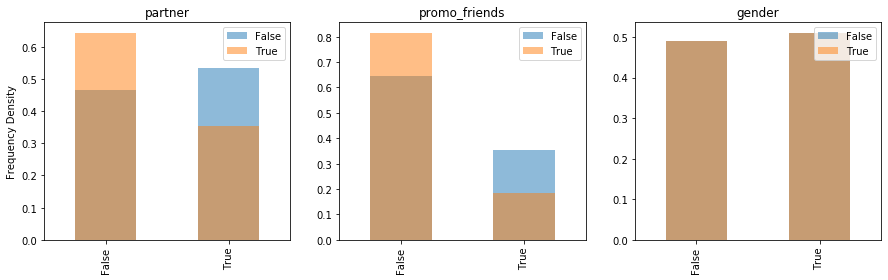

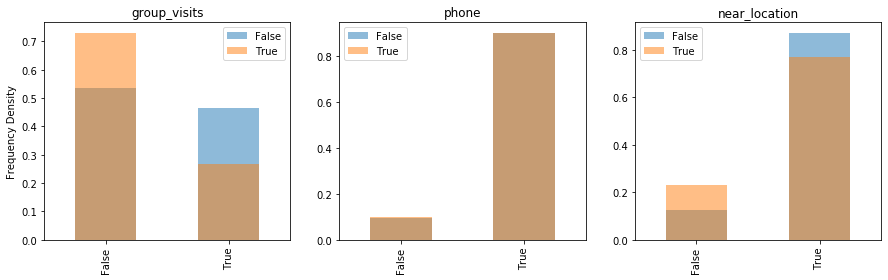

Distribution of numerical features by churn:


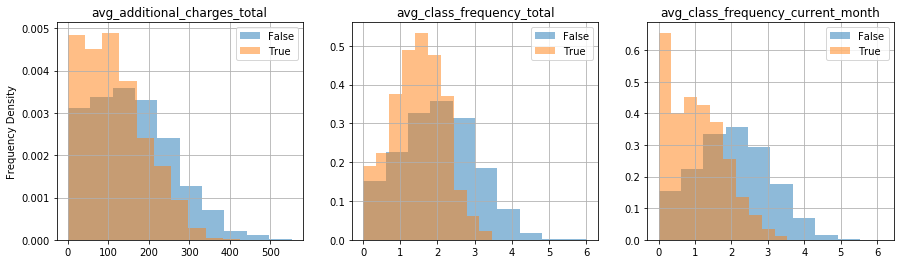

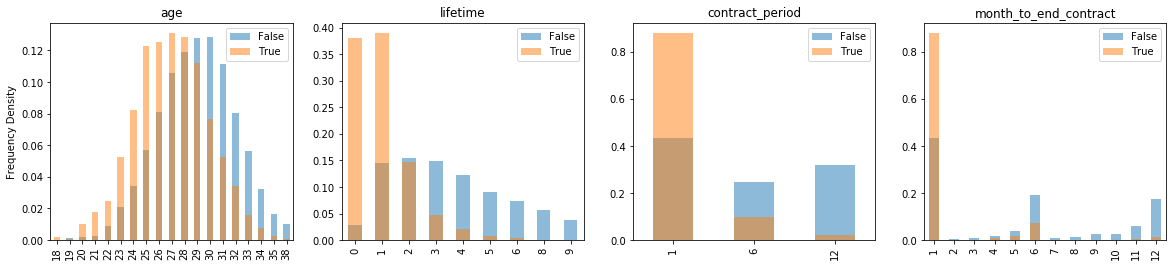

In [5]:
# Let's look at feature values in two groups: for those who left (churn=1) and for those who stayed 

# function to plot density chart
def density_plot_by_churn(feature, ax):
    for name, group_data in data.groupby('churn'): 
        group_data[feature].hist(density=True, alpha=0.5, ax=ax, label=name)
        ax.set_title(feature)
        ax.legend()

# function to plot several density plots in a row
def density_compare(features):
    cols_num = len(features)
    fig, axes = plt.subplots(ncols=cols_num, figsize=(5*cols_num, 4))
    for i, feature in enumerate(features):
        density_plot_by_churn(feature, axes[i])
    axes[0].set_ylabel('Frequency Density');
    plt.show()

# function to plot several density plots for discrete features in a row
def density_compare_int(features):
    cols_num = len(features)
    fig, axes = plt.subplots(ncols=cols_num, figsize=(5*cols_num, 4))
    for i, feature in enumerate(features):
        for name, group_data in data.groupby('churn'): 
            (group_data[feature].value_counts()/len(group_data)).sort_index()\
                .plot(kind='bar', ax=axes[i], alpha=0.5, label=name, 
                      color=next(axes[i]._get_lines.prop_cycler)['color'])       
            axes[i].set_title(feature)
            axes[i].legend()
    axes[0].set_ylabel('Frequency Density');
    plt.show()

# function to highlight differences in mean values of more than 5% and 20%
def row_style(row):
    if abs(row[0] - row[1])/row[0] > 0.2:
        return pd.Series('color: red', row.index)
    if abs(row[0] - row[1])/row[0] > 0.05:
        return pd.Series('color: orange', row.index)
    else:
        return pd.Series('', row.index)
    
print(BOLD + 'The mean feature values in two groups: for those who left and for those who stayed:' + END)
display(data[boolean_cols+float_cols+int_cols].groupby('churn').agg('mean').T.round(2).style.apply(row_style, axis=1))
print()

print(BOLD + 'Distribution of boolean features by churn:' + END)
for cols in np.array_split(list(set(boolean_cols) - set(['churn'])), 2):
    density_compare_int(cols)
    
print(BOLD + 'Distribution of numerical features by churn:' + END)
density_compare(float_cols)
density_compare_int(int_cols)

The share of men and women among those who left and those who stayed is the same and is about 50%. The shares of clients who did not provide their phone numbers in these two churn groups are also the same and amount to almost 10%.

The share of clients participating in the partner program among those who continue to use the services of the gym is about 50%, the share of partner program participants among those who left is much smaller - only 36%. The share of clients participating in group sessions among those who stayed is also almost 50%, but the share of group training participants among the churn is much smaller - only 27%.

The share of customers who registered under the "bring a friend" campaign among those who stayed is 35%, among those who left - less and amounts to 18%. 

The share of clients living or working near the gym among those who stayed is 87%, among those who left - a little less and amounts to 77%. The share of clients who live or work near the gym, among those who stayed, 87%, among those who left - less and amounts to 77%. Those who live further from the gym are more likely to stop using its services.

The distribution of additional spending to customers who stayed has a lot of variation and is biased towards larger average purchases, on average by \$40.

The distribution of the frequency of visits per week for clients who stayed also has larger variation than for those who left and is biased towards more workouts per week. The distribution of the frequency of visits per week over the last month for clients who left is more biased towards fewer workouts per week and has a peak at zero. It makes sense to __create a feature corresponding to the difference between the weekly frequency of visits over the lifetime and the frequency of visits over the last month__ to track the dynamics of visits. 

The distribution of the age of the clients who left is shifted towards the younger age groups.

The lifetime of loyal clients is almost 4 months longer on average. A large share of clients who left worked out for a month or even less.

Almost 90% of clients who left had a one-month contract, while among loyal customers about 40% of clients have a one-month contract. Note that there are only one-month, half-year, and annual contracts. Due to the large proportion of one-month contracts, the share of customers who have one month left until the contract expires is the same. The values 6 and 12 stand out. The share of users with different values is very small. It looks like most of the contracts were signed or extended recently.

There are no outlier values on the distribution plots.

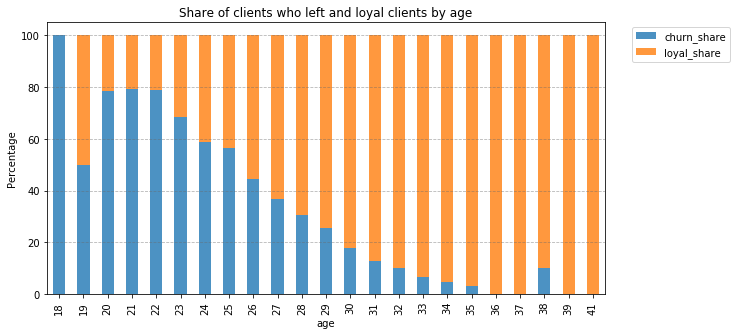

In [6]:
# Let's take a closer look at the age of clients who left and loayl clients.
fig, ax = plt.subplots(figsize=(10, 5))
data.pivot_table(index='age', columns='churn', values='gender', aggfunc='count').fillna(0)\
    .assign(churn_share=lambda x: 100*x[True]/(x[True]+x[False]),
            loyal_share=lambda x: 100*x[False]/(x[True]+x[False]))[['churn_share', 'loyal_share']]\
    .plot(kind='bar', stacked=True, alpha=0.8, ax=ax);
ax.set_title('Share of clients who left and loyal clients by age')
ax.set_ylabel('Percentage')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left");
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5);

The churn rate for clients under 25 is quite high. After 32 years, it is very low. __It makes sense to pay attention to customers under the age of 25.__

Distribution of the new feature corresponding to the difference between the weekly frequency of visits over the 
lifetime and the frequency of visits over the last month in two groups: for those who left and for those who stayed


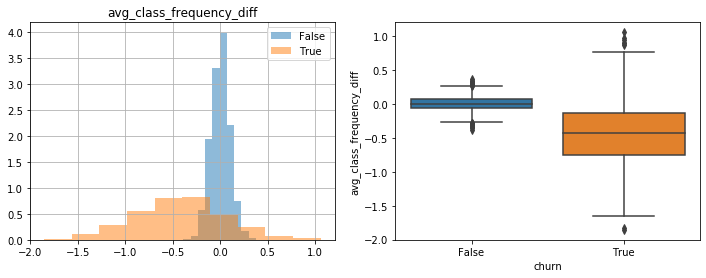

The mean in two groups: for those who left and for those who stayed


,avg_class_frequency_diff
churn,
False,0.00
True,-0.43


In [7]:
# creating new feature: 
# the difference between the weekly frequency of visits over the lifetime 
#                    and the frequency of visits over the last month
data['avg_class_frequency_diff'] = data.avg_class_frequency_current_month - data.avg_class_frequency_total
float_cols += ['avg_class_frequency_diff']

print(BOLD + 'Distribution of the new feature ' + END
           + 'corresponding to the difference between the weekly frequency of visits over the \nlifetime ' 
           + 'and the frequency of visits over the last month in two groups: ' 
           + 'for those who left and for those who stayed' )
fig, axes = plt.subplots(ncols=2, figsize=(6*2, 4))
density_plot_by_churn('avg_class_frequency_diff', axes[0])
sns.boxplot(y='avg_class_frequency_diff', x='churn', data=data, ax=axes[1]);
plt.show()

print(BOLD + 'The mean in two groups: for those who left and for those who stayed' + END)
display(data[['avg_class_frequency_diff', 'churn']].groupby('churn').agg('mean').round(2))

Training frequency for loyal users doesn't change last month.

The distribution of the frequency of visits per week for clients who left has significantly more variation than for those who stayed, and is biased towards decreasing the number of workouts per week.

Correlation matrix:


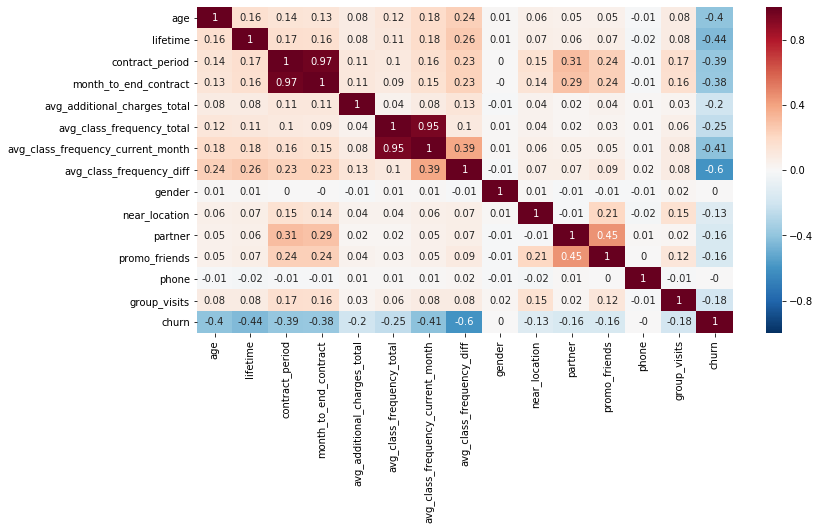

In [8]:
# Let's look at correlations between features
print(BOLD + 'Correlation matrix:' + END)
fig, ax = plt.subplots(figsize=(12, 6)) 
sns.heatmap(data[int_cols+float_cols+boolean_cols].corr().round(2),
            annot=True, ax=ax, vmin=-1, vmax=1, cmap='RdBu_r');

Pairs of features `'contract_period'`, `'month_to_end_contract'` and `'avg_class_frequency_total'`, `'avg_class_frequency_current_month'` have very strong positive correlations. It is necessary to exclude one feature from each pair when building models that are sensitive to multicollinearity or to use regularization. Features `'avg_class_frequency_current_month'` and `'avg_class_frequency_diff'` have a correlation coefficient of 0.39 since the feature `'avg_class_frequency_diff'` was calculated based on the features `'avg_class_frequency_total'` and `'avg_class_frequency_current_month'`. The latter can be removed from consideration.

Features `'partner'` and `'promo_friends'` have a correlation coefficient of 0.45. Apparently many clients participated in both customer acquisition programs. These features are correlated with `'contract_period'` on the level of 0.30. Users attracted by these programs are likely to buy longer subscriptions more often.

The correlation between `'gender'`, `'phone'` and the target variable (`'churn'`) is zero. The rest of the features have a weak or moderate negative correlation with the target one. Thus, __churn corresponds to__ 
* younger age
* shorter lifetime
* shorter contract period
* fewer months before contract expiration
* fewer workouts last month

## 3. Building a Model to Predict Customer Churn
<a id='section3'></a>

Metric values for different types of binary classification algorithms:


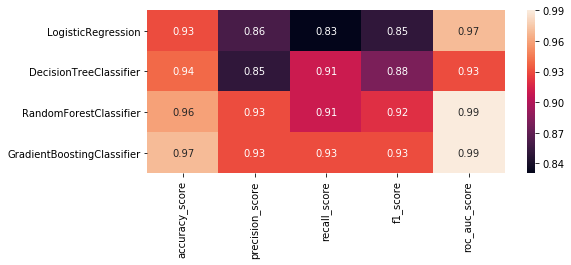

In [9]:
# function to train several models to select the best one
def training(data):

    # dividing the data into features (the X matrix) and a target variable (y) 
    X = data.drop('churn', axis = 1) 
    y = data['churn']

    # dividing the data into train and test sets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # training StandardScaler on the train set 
    scaler = StandardScaler() 
    scaler.fit(X_train) 

    # transforming train and test sets 
    X_train_st = scaler.transform(X_train) 
    X_test_st = scaler.transform(X_test) 

    # Let's make a list of models
    # models that require normalized data:
    models_st = [LogisticRegression(solver='liblinear', random_state=0)]
    
    # models that don't require normalized data:
    models = [DecisionTreeClassifier(random_state=0), 
              RandomForestClassifier(n_estimators=100, random_state=0),
              GradientBoostingClassifier(random_state=0)]

    # Let's make a list of metrics.
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    # metrics for which it is preferable to use probability values rather than a vector of predictions:
    metrics_proba = [roc_auc_score]

    # creating a log variable to record the metrics values of the rained models
    training_logs = []
    models_names = []
    
    # the function that takes the model and data as input and outputs metrics 
    def make_prediction(m, X_train, y_train, X_test, y_test): 

        m.fit(X_train, y_train) 
        y_pred = m.predict(X_test)
        y_pred_proba = m.predict_proba(X_test)[:,1]
        metrics_values = [metric(y_test, y_pred) for metric in metrics]
        metrics_values += [metric(y_test, y_pred_proba) for metric in metrics_proba]
        training_logs.append(metrics_values)
    
    # training the models
    
    for model in models_st:
        models_names.append(model.__class__.__name__)
        make_prediction(model, X_train_st, y_train, X_test_st, y_test)

    for model in models:
        models_names.append(model.__class__.__name__)
        make_prediction(model, X_train, y_train, X_test, y_test)
    
    return pd.DataFrame(training_logs, 
                    columns=list(map(lambda x: x.__name__, metrics+metrics_proba)), 
                    index=models_names).round(2)


# Let's not include features with zero correlation with the target variable in the model,
# as well as excess features 'avg_class_frequency_current_month'. 
# We will leave features with strong cross-correlation, 
# since the LogisticRegression impregnation contains regularization, 
# and the rest of the models are not sensitive to multicollinearity.
features = list(set(data.columns) - set(['gender', 'phone', 'avg_class_frequency_current_month']))

print(BOLD + 'Metric values for different types of binary classification algorithms:' + END) 
# printing metrics for all the algorithms 
fig, ax = plt.subplots(figsize=(8, 3)) 
sns.heatmap(training(data[features]), annot=True, ax=ax);

__Gradient boosting is more accurate, precise and detects more cases of outflow (see recall) than other algorithms__. Logistic regression and decision tree perform well, although the recall of trees is higher, and for our task it is important to identify more cases of churn with an acceptable level of precision. Ensembles yield a good result comparable to gradient boosting.

Metric values for different types of binary classification algorithms based on initial features:


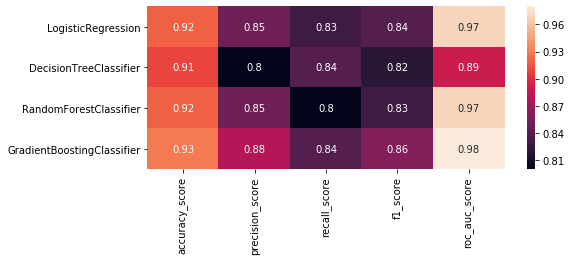

In [10]:
# Let's look at the models based on intial features
initial_features = list(set(data.columns) - set(['avg_class_frequency_diff']))

print(BOLD + 'Metric values for different types of binary classification algorithms based on initial features:' + END)
fig, ax = plt.subplots(figsize=(8, 3)) 
sns.heatmap(training(data[initial_features]), annot=True, ax=ax);

The results on all initial data are approximately the same for all algorithms and worse than with an additionally created feature and excluded excess features, except for logistic regression.

Feature importance:


,score
avg_class_frequency_diff,0.7309
lifetime,0.1489
age,0.0350
avg_class_frequency_total,0.0273
month_to_end_contract,0.0252
contract_period,0.0220
avg_additional_charges_total,0.0076
group_visits,0.0016
near_location,0.0008
promo_friends,0.0008


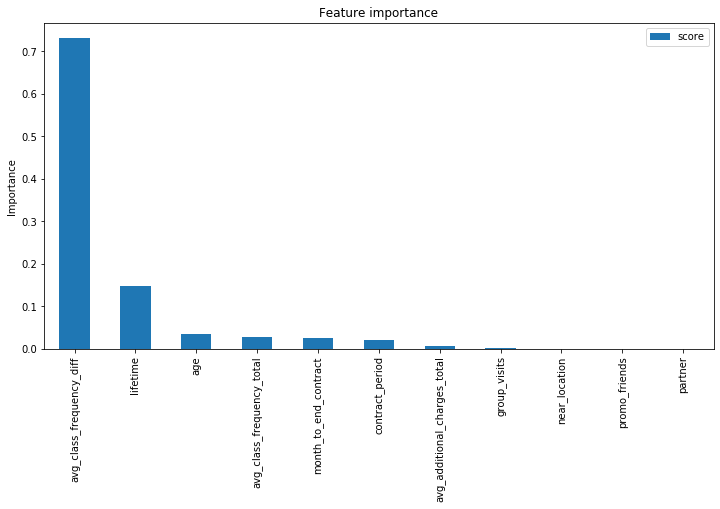

In [11]:
# Let's look at the factors that impact churn most.
# To do this, we calculate the importance of the features for gradient boosting.

# dividing the data into features (the X matrix) and a target variable (y) 
X = data[features].drop('churn', axis = 1) 
y = data['churn']

# dividing the data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# training gradient boosting classifier
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)

# summarizing feature importance
importance = pd.DataFrame({'score': model.feature_importances_}, index=X_train.columns)\
                .sort_values('score', ascending=False)

print(BOLD + 'Feature importance:' + END)
display(importance.round(4))

# ploting feature importance
fig, ax = plt.subplots(figsize=(12, 6))
importance.plot(kind='bar', ax=ax);
ax.set_title('Feature importance');
ax.set_ylabel('Importance');

__The created feature that reflects the dynamics of attendance in the last month in comparison with the usual gym attendance (`'avg_class_frequency_diff'`) has the greatest contribution to the model.__ `'Lifetime'` also has a high importance ratio. Then comes the `'age'`, average attendance (`'avg_class_frequency_total'`), contract duration (`'contract_period'`) and the amount of additional spending (`'avg_additional_charges_total'`).

## 4. Clastering Customers
<a id='section4'></a>

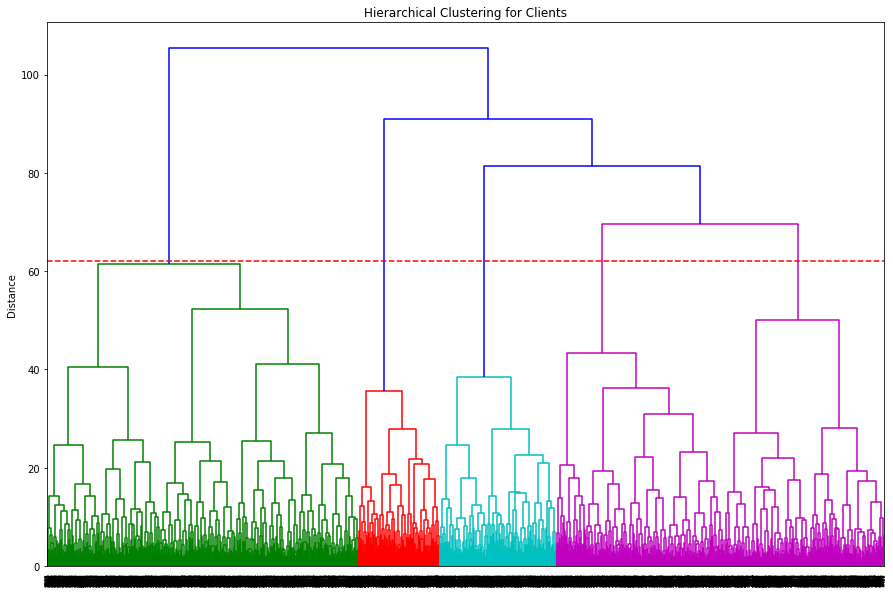

In [12]:
# Let's segment customers and draw up user portraits.

# Let's plot the dendrogram to visually estimate the necessary number of clusters
# function to plot a dendrogram
def plot_dendrogram(X, distance_level=None):
    # standardizing the data
    scaler = StandardScaler()
    X_st = scaler.fit_transform(X)
    
    # building a matrix of distances based on the standardized feature matrix
    linked = linkage(X_st, method = 'ward')
    
    # ploting a dendrogram
    plt.figure(figsize=(15, 10))   
    dendrogram(linked, orientation='top');
    plt.title('Hierarchical Clustering for Clients');
    plt.ylabel('Distance');
    if distance_level is not None:
        plt.axhline(c='r',linestyle='--', y=distance_level);
        
# setting aside the column with data on churn 
X = data.drop('churn', axis = 1)

# plotting the dendrogram
plot_dendrogram(X, 62)

With help of agglomerative hierarchical clustering, we can visually estimate the necessary number of clusters as 4 according to colloring clusters on the dendrogram, or as 5 choosing the distance thresholds from 62 to about 70, or even as 6 slightly lowering the distance threshold.

Clustering for 5 clusters
The mean feature values for clusters, in standardized coorditanes:


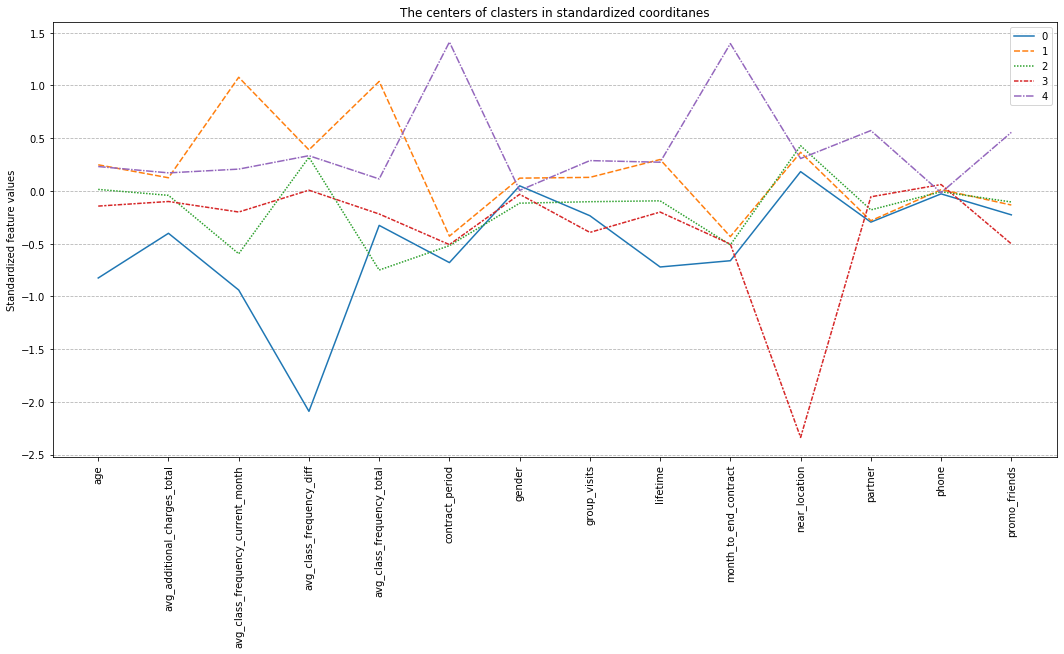

The mean feature values for clusters (cluster centers):


cluster_km,0,1,2,3,4
gender,0.534274,0.570628,0.451988,0.494094,0.512582
near_location,0.911290,0.977578,1.000000,0.000000,0.956198
partner,0.338710,0.345291,0.396702,0.458661,0.772600
promo_friends,0.203629,0.246637,0.259942,0.076772,0.564772
phone,0.895161,0.906951,0.901067,0.921260,0.898416
contract_period,1.588710,2.728700,2.320078,2.364173,11.099720
group_visits,0.296371,0.475336,0.361785,0.218504,0.553588
age,26.493952,29.989910,29.229874,28.714567,29.936626
avg_additional_charges_total,108.210500,158.921618,142.862557,137.252302,163.400703
month_to_end_contract,1.548387,2.506726,2.179437,2.208661,10.175210


The number of clients in each cluster:


cluster_km,0,1,2,3,4
count,496,892,1031,508,1073


In [13]:
# Let's segment customers with help of the K-means algorithm and build 5 clusters

# function to train the clustering model with the K-means algorithm
def clustering(n, X, churn):
    
    # standardizing the data
    scaler = StandardScaler()
    X_st = scaler.fit_transform(X)
    
    # train the clustering model with the K-means algorithm and predicting customer clusters 
    km = KMeans(random_state=0, n_clusters = n) 
    labels = km.fit_predict(X_st)
    
    # Let's find the centers of clasters in standardized coorditanes
    X_st_with_clasters = pd.DataFrame(X_st, columns=X.columns)
    X_st_with_clasters['cluster_km'] = labels
    centers_st = X_st_with_clasters.groupby('cluster_km').agg('mean').T
    
    # ploting the centers of clasters in standardized coorditanes
    print(BOLD + 'The mean feature values for clusters, in standardized coorditanes:' + END)
    fig, ax = plt.subplots(figsize=(18, 8))
    sns.lineplot(data=centers_st, ax=ax);
    ax.xaxis.set_tick_params(rotation=90)
    ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    ax.set_title('The centers of clasters in standardized coorditanes')
    ax.set_ylabel('Standardized feature values')
    plt.show()
    
    print(BOLD + 'The mean feature values for clusters (cluster centers):' + END)
    X_with_churn = X.copy()
    X_with_churn['churn'] = churn
    X_with_churn['cluster_km'] = labels
    display(X_with_churn.groupby('cluster_km').agg('mean').T)
    
    print(BOLD + 'The number of clients in each cluster:' + END)
    display(X_with_churn.groupby('cluster_km').cluster_km.agg(['count']).T)
    
    return X_with_churn

# K-means clustering for 5 clusters
print(BOLD + 'Clustering for 5 clusters' + END)
X_with_clusters = clustering(5, X, data.churn)

We can identify a cluster of clients who have been workouting much less frequently over the last month (see the cluster with drop in the `'avg_class_frequency_diff'` feature). These clients also have younger age, the lowest attendance (they do not workout every week, mean of `'avg_class_frequency_current_month'` is lower than 1), shorter lifetime, shorter contracts and a bit lower extra spending, moreover there is little time remaining until the contract expires. The churn of this cluster is almost 100%.

We can also identify a cluster of clients who have recently entered into or renewed long-term contracts (see the cluster with peakes in the `'contract_period'` and `'month_to_end_contract'` features). These clients are older, have slightly above average attendance, extra spendings and lifetime, attended group sessions, were attracted through a partner program, or/and were registered under the "bring a friend" campaign. Their churn is very low, about 2%.

Another cluster that we can distinguish corresponds to clients with high attendance, which hardly changed over the past month (see the cluster with spikes in `'avg_class_frequency_total'` and `'avg_class_frequency_current_month'`). These clients are also older, have relatively shorter contact periods and slightly above average lifetime. Their churn is relatively low, about 7%.

We can also distinguish a cluster that corresponds to clients with an initially low frequency of visits which has practically not changed over the last month (see the cluster with the lowest mean of `'avg_class_frequency_total'`). The rest of the cluster centers approximately correspond to the average values of the features. The churn of this cluster is about 30%.

The last cluster correspond clients with closest location stand out, the rest of the cluster centers are slightly lower or equal to the average values of the features.

The 'phone' and 'near_location' features hardly affect user churn as well as 'gender'.  These feature weakly divide clients into segments, or they are not divided them stably due to the overlay of feature values in the nearest clusters. 

To develop the strategy for customer interaction and retention it makes sense to segment clients regarding churn. For these purposes we can conduct clustering according to features that noticeably affect the churn.

Let's consider features with noticable importance in our churn predictive model.

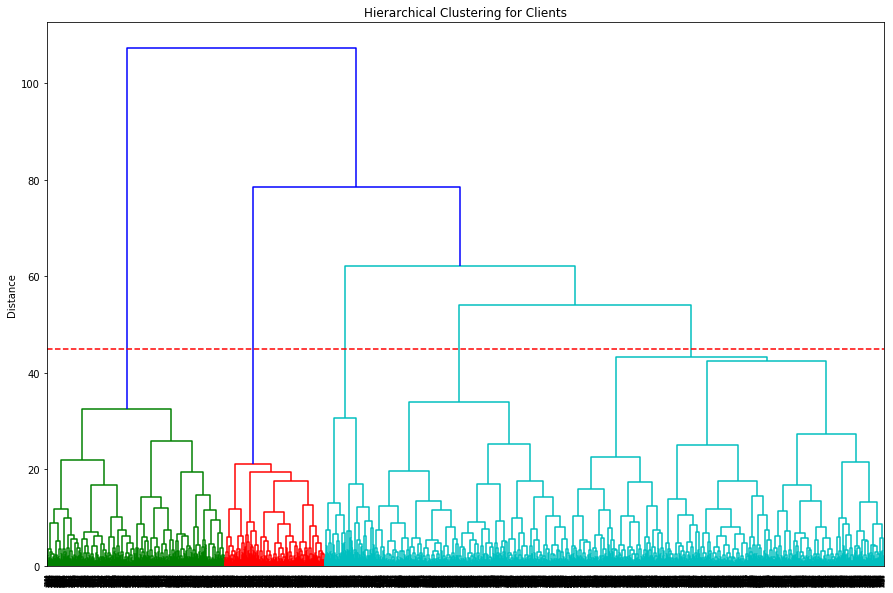

In [14]:
# Let's plot the dendrogram to visually estimate the necessary number of clusters 
important_features = ['avg_class_frequency_diff', 'lifetime', 'age', 'avg_class_frequency_total', 'contract_period',
                   'month_to_end_contract', 'avg_additional_charges_total']
plot_dendrogram(X[important_features], 45)

We can visually estimate the number of clusters as 5 choosing the distance threshold of about 45.

The mean feature values for clusters, in standardized coorditanes:


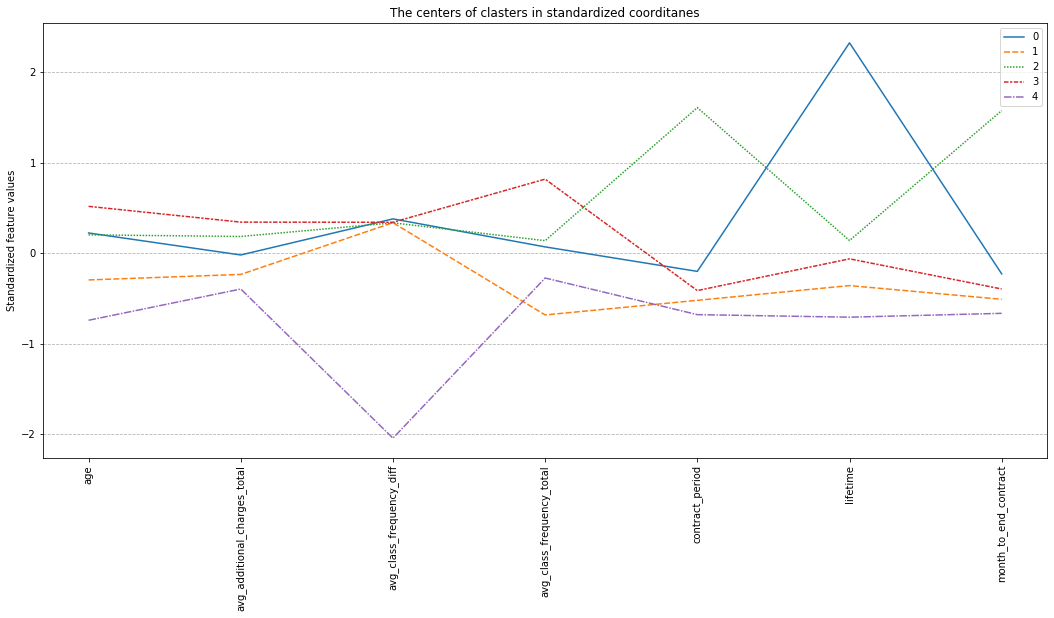

The mean feature values for clusters (cluster centers):


cluster_km,0,1,2,3,4
avg_class_frequency_diff,0.009832,-0.003640,-0.004277,-0.002204,-0.769037
lifetime,12.442073,2.381557,4.248373,3.489447,1.071553
age,29.911585,28.219966,29.843818,30.870352,26.767888
avg_class_frequency_total,1.946443,1.215201,2.013330,2.674616,1.612120
contract_period,3.765244,2.308799,12.000000,2.800000,1.589878
month_to_end_contract,3.362805,2.185279,10.927332,2.663317,1.535777
avg_additional_charges_total,145.012578,124.308621,164.719686,179.993201,108.749058
churn,0.000000,0.358714,0.021692,0.044221,1.000000


The number of clients in each cluster:


cluster_km,0,1,2,3,4
count,328,1182,922,995,573


In [15]:
# K-means clustering for 5 clusters based on features that noticeably affect the churn.
X_with_clusters_imp = clustering(5, X[important_features], data.churn)

We can identify clusters of clients with the following key behaviors:
* __i.__ a cluster of clients who have been workouting much less frequently over last month (see the cluster with drop in the `'avg_class_frequency_diff'` feature). The churn of this cluster is 100%.
* __ii.__ a cluster of clients who have signed long-term contracts and there is a lot of time left before the expiration of the contract (see the cluster with peakes in the `'contract_period'` and `'month_to_end_contract'` features). Their churn is very low, about 2%.
* __iii.__ a cluster of clients with high frequency of visits, which hardly changed over the past month (see the cluster with spikes in `'avg_class_frequency_total'`). Their churn is relatively low, about 4%.
* __iv.__ a cluster of clients with an initially low frequency of visits which has practically not changed over the last month (see the cluster with the lowest mean of `'avg_class_frequency_total'`). The churn of this cluster is about 36%.
* __v.__ a cluster of clients with longer lifetime (see the cluster with peakes in the `'lifetime'` feature, the lifetime is a year on average). These clients are loyal, nobody has stopped going to the gym.

Distributions of features for the clusters:


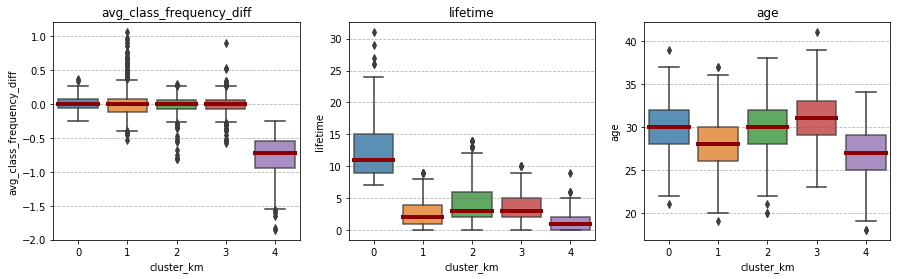

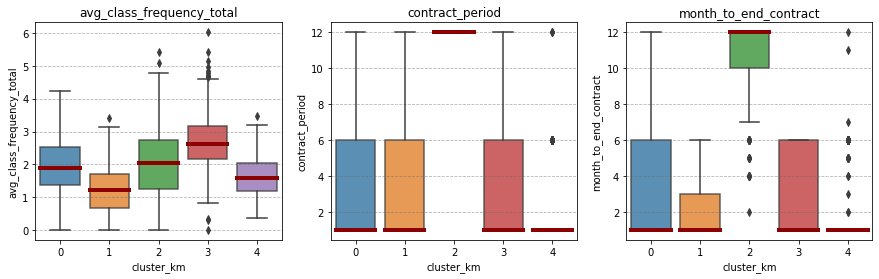

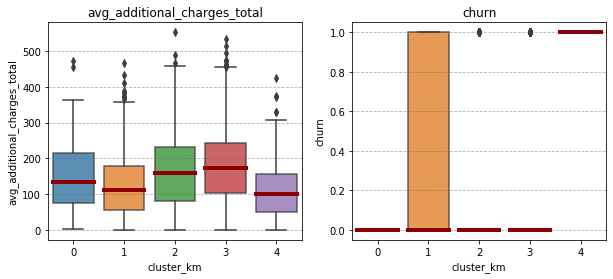

In [16]:
# Let's consider in more detail the distribution of features for each cluster.
print(BOLD + 'Distributions of features for the clusters:' + END)
features = X_with_clusters_imp.drop('cluster_km', axis = 1).columns
for i, feature in enumerate(features):
    if i % 3 == 0:
        cols_num = 2 if i==(len(features)//3 * 3) else 3
        fig, axes = plt.subplots(ncols=cols_num, figsize=(5*cols_num, 4))
    sns.boxplot(x='cluster_km', y=feature, data=X_with_clusters_imp, ax=axes[i%3],
                medianprops={'linewidth': 4, 'c':'darkred'}, boxprops={'alpha': 0.8})
    axes[i%3].set_title(feature);
    axes[i%3].grid(axis='y', linestyle='--', color='dimgray', alpha=0.5);

__i.__ Clients of the cluster with the dynamics of reducing the frequency of classes have:
* the lowest lifetime (not longer than 2 months, 1 month on average)
* lower age
* not high frequency of classes (1-2 classes per week)
* mostly one-month contracts
* slightly less extra spendings
* left

__ii.__ Clients of the cluster with long-term contracts have:
* a constant frequency of classes on average (but some clients nevertheless began to workout a little less often)
* an average lifetime (2 to 6 months)
* a variety of classes frequencies (on average 2 workouts per week)
* only one-year contracts
* a long time before the end of the contract (for the majority there are still 10-12 months left)
* slightly more additional spendings
* mostly stayed

__iii.__ Clients of the cluster with initialy higher class frequencies:
* have a constant frequency of classes on average 
* not a very long lifetime (3 to 5 months)
* are of an older age
* mostly signed one-month contracts (some clients signed half-yearly contracts and some did annual ones)
* have slightly more extra spendings
* mostly stayed

__iv.__ Clients of the cluster with initialy low class frequencies have:
* a constant frequency of classes on average
* not a very long lifetime (1 to 4 months)
* lower age
* mostly signed one-month contracts (some clients signed half-yearly contracts and some did annual ones)
* a little time before the end of the contract (1-3 months)
* slightly less extra spendings
* stayed on avarage (but more than a third of clients have left)

__v.__ Clients of the cluster with longer lifetime:
* regularly workout, the frequency of their activities has not changed
* have long lifetime (more than half a year, on average a year)
* a variety of classes frequencies (on average 2 workouts per week)
* mostly signed one-month contracts (some clients signed half-yearly contracts and some did annual ones)
* stayed

## 5. Overall conclusion and basic recommendations
<a id='section5'></a>

There are some data on __clients profiles of the gym chain__ to study __user churn__ and __develope a customer interaction strategy__.

The dataset contains data from the log of visits and purchases of 4,000 clients as well as data on current membership status. 

__Some general information about clients__:
* The age of the gym client varies from 18 to 41 years (29 years on average).
* An average lifetime is 3 months (there are clients who have been going to the gym for more than 2.5 years).
* There are contracts from a month to a year. At least half of the clients only have one-month contracts.
* Clients spend on average \$150 on other gym services such as cafes, sporting goods, massage, etc.
* The average gym client works out twice a week. 

__A predictive model__ of the likelihood of user __churn__ was built based on the gradient boosting algorithm with a __recall of 93%__ and __a precision of 93%__ as well. 
__The factors that impact churn most__, according to the model are changing the frequency of classes, lifetime, age, workout frequency, contract period, extra spending. Dynamics of changes in the frequency of classes has the greatest contribution to the model.

During the correlation analysis, it was found that __the churn corresponds to__:
* fewer workouts last month
* younger age
* shorter lifetime
* shorter contract period
* less workout frequency
* fewer extra spendings

__User segments__ have been identified with the following key behaviors:
1. Clients who have been workouting less frequently over last month. They have small lifetimes (not longer than 2 months), younger age (mostly less than 30 years, 27 years on average), not high frequency of classes (1-2 classes per week) and mostly one-month contracts.
2. Clients with an initially low frequency of visits. They have not a very long lifetime (1 to 4 months), younger age (mostly not greater than 30 years, 28 years on average) and a little time before the end of the contract (1-3 months).
3. Clients with high frequency of workouts (about 3 classes per week on avarage). They are slightly older than the average age of clients and spend a little more money on additional services.
4. Clients who have recently signed annual contracts.
5. Clients with long lifetime (more than half a year, on average a year). They regularly workout, the frequency of their activities has not changed.

The first segment has 100% churn, the last one has zero. The churn rate for the second segment is 36%. The churn rate for the other two segments is relatively small - 4% and 2%, respectively. 

__Recommendations on a customer retention strategy__:
* Tracking negative dynamics of changes in the frequency of classes is a key measure to cut churn. We can put clients at risk group for churn if they start workout less often. It makes sense to target these customers.
* Clients under 30 are at risk for churn. It makes sense to pay attention to these customers.
* Clients with a one-month contract are also more prone to churn, so it pays to motivate clients to enter into longer-term contracts.
* It makes sense to try to increase the frequency of workouts by offering discounts or promotions to clients who visit the gym only once a week.
* It is worth monitoring clients who have just started attending the gym within the first four months by encouraging them to regularly visit the gym 2-3 times a week.
* It makes sense to add a feature corresponding to the revenue for each clients and include it in the segmentation or estimate the total and average revenue for customer segments or even age group for a more accurate selection of the retention strategy.